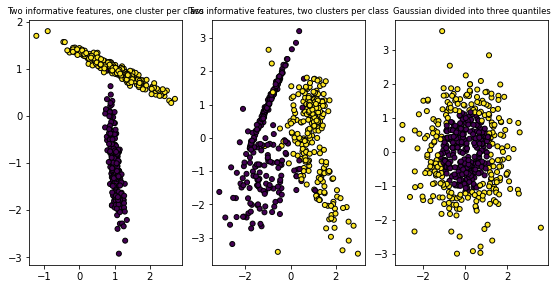

In [13]:
import matplotlib.pyplot as plt
import time
from sklearn.datasets import make_classification
from sklearn.datasets import make_blobs
from sklearn.datasets import make_gaussian_quantiles
from sklearn.model_selection import train_test_split
plt.figure(figsize=(8, 4))
plt.subplots_adjust(bottom=.05, top=.9, left=.05, right=.95)


plt.subplot(131)
plt.title("Two informative features, one cluster per class", fontsize='small')
X1, Y1 = make_classification(n_samples=500,n_features=2, n_redundant=0, n_informative=2,
                             n_clusters_per_class=1)
plt.scatter(X1[:, 0], X1[:, 1], marker='o', c=Y1,
            s=25, edgecolor='k')

plt.subplot(132)
plt.title("Two informative features, two clusters per class",
          fontsize='small')
X2, Y2 = make_classification(n_samples=500, n_features=2, 
                             n_redundant=0, 
                             n_informative=2)
plt.scatter(X2[:, 0], X2[:, 1], marker='o', c=Y2,
            s=25, edgecolor='k')


plt.subplot(133)
plt.title("Gaussian divided into three quantiles", fontsize='small')
X3, Y3 = make_gaussian_quantiles(n_samples=500,n_features=2, n_classes=2)
plt.scatter(X3[:, 0], X3[:, 1], marker='o', c=Y3,
            s=25, edgecolor='k')

plt.show()  # various graphs

In [2]:
from random import seed
from random import randrange
from csv import reader
from math import sqrt
from math import exp

In [3]:
# Split a dataset into k folds
def cross_validation_split(dataset, n_folds):
    dataset_split = list()
    dataset_copy = list(dataset)
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds):
        fold = list()
        while len(fold) < fold_size:
            index = randrange(len(dataset_copy))
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold)
    return dataset_split


# Calculate accuracy percentage
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
          correct += 1
    return correct / float(len(actual)) * 100.0


# Evaluate an algorithm using a cross validation split
def evaluate_algorithm(dataset, algorithm, n_folds, *args):
    folds = cross_validation_split(dataset, n_folds)
    scores = list()
    for fold in folds:
        train_set = list(folds)
        train_set.remove(fold)
        train_set = sum(train_set, [])
        test_set = list()
        for row in fold:
            row_copy = list(row)
            test_set.append(row_copy)
            row_copy[-1] = None
        predicted = algorithm(train_set, test_set, *args)
        actual = [row[-1] for row in fold]
        accuracy = accuracy_metric(actual, predicted)
        scores.append(accuracy)
    return scores

# Base Learner: SVM

In [4]:
# import section for optimization, plotting  kütüphanelerinin  import edilmesi
import numpy as np    
# For optimization
from scipy.optimize import Bounds, BFGS                     
from scipy.optimize import LinearConstraint, minimize   
# For plotting
import matplotlib.pyplot as plt
import seaborn as sns
# For generating dataset
import sklearn.datasets as dt
from sklearn.metrics import accuracy_score

In [5]:
import numpy as np

class SVM:
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.w = None
        self.b = None

    def fit(self, X, y):
        n_samples, n_features = X.shape

        y_ = np.where(y <= 0, -1, 1)

        self.w = np.zeros(n_features)
        self.b = 0

        for _ in range(self.n_iters):
            for idx, x_i in enumerate(X):
                condition = y_[idx] * (np.dot(x_i, self.w) - self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (
                        2 * self.lambda_param * self.w - np.dot(x_i, y_[idx])
                    )
                    self.b -= self.lr * y_[idx]
    
    def svm_model(self, train): # Ağırlıkların kaydedilmesi için gerekli fonksiyon
        weights = np.array(self.w)
        return weights

    def predict(self, X, y):
        approx = np.dot(X, self.w) - self.b
        return np.sign(approx)

# Base Learner: KNN

In [17]:
# Calculate the Euclidean distance between two vectors
def euclidean_distance(row1, row2):
    distance = 0.0
    for i in range(len(row1)-1):
        distance += (row1[i] - row2[i])**2
    return sqrt(distance)

# Locate neighbors for a new row
def get_neighbors(train, test_row, num_neighbors):
    distances = list()
    for train_row in train:
        dist = euclidean_distance(test_row, train_row)
        distances.append((train_row, dist))
    distances.sort(key=lambda tup: tup[1])
    neighbors = list()
    for i in range(num_neighbors):
        neighbors.append(distances[i][0])
    return neighbors

# Make a prediction with kNN
def knn_predict(model, test_row, num_neighbors=2):
    neighbors = get_neighbors(model, test_row, num_neighbors)
    output_values = [row[-1] for row in neighbors]
    prediction = max(set(output_values), key=output_values.count)
    return prediction

# Prepare the kNN model
def knn_model(train):
    return train

# Base Learner: Perceptron

In [18]:
# Make a prediction with weights
def perceptron_predict(model, row):
    activation = model[0]
    for i in range(len(row)-1):
        activation += model[i + 1] * row[i]
    return 1.0 if activation >= 0.0 else 0.0

# Estimate Perceptron weights using stochastic gradient descent
def perceptron_model(train, l_rate=0.01, n_epoch=5000):
    weights = [0.0 for i in range(len(train[0]))]
    for epoch in range(n_epoch):
        for row in train:
            prediction = perceptron_predict(weights, row)
            error = row[-1] - prediction
            weights[0] = weights[0] + l_rate * error
            for i in range(len(row)-1):
                weights[i + 1] = weights[i + 1] + l_rate * error * row[i]
    return weights

# Meta Learner: Logistic Regression

In [19]:
# Make a prediction with coefficients
def logistic_regression_predict(model, row):
    yhat = model[0]
    for i in range(len(row)-1):
        yhat += model[i + 1] * row[i]
    return 1.0 / (1.0 + exp(-yhat))

# Estimate logistic regression coefficients using stochastic gradient descent
def logistic_regression_model(train, l_rate=0.01, n_epoch=5000):
    coef = [0.0 for i in range(len(train[0]))]
    for epoch in range(n_epoch):
        for row in train:
          yhat = logistic_regression_predict(coef, row)
          error = row[-1] - yhat
          coef[0] = coef[0] + l_rate * error * yhat * (1.0 - yhat)
          for i in range(len(row)-1):
              coef[i + 1] = coef[i + 1] + l_rate * error * yhat * (1.0 - yhat) * row[i]
    return coef

In [20]:
# Make predictions with sub-models and construct a new stacked row
def to_stacked_row(models, predict_list, row):
	stacked_row = list()
	for i in range(len(models)):
		prediction = predict_list[i](models[i], row)
		stacked_row.append(prediction)
	stacked_row.append(row[-1])
	return row[0:len(row)-1] + stacked_row
 

In [29]:
# Stacked Generalization Algorithm
clf = SVM()
def stacking(train, test):
		model_list = [knn_model, perceptron_model, clf.svm_model]
		predict_list = [knn_predict, perceptron_predict, clf.predict]
		models = list()
		for i in range(len(model_list)):
				model = model_list[i](train)
				models.append(model)
		stacked_dataset = list()
		for row in train:
				stacked_row = to_stacked_row(models, predict_list, row)
				stacked_dataset.append(stacked_row)
		stacked_model = logistic_regression_model(stacked_dataset)
		predictions = list()
		for row in test:
				stacked_row = to_stacked_row(models, predict_list, row)
				stacked_dataset.append(stacked_row)
				prediction = logistic_regression_predict(stacked_model, stacked_row)
				prediction = round(prediction)
				predictions.append(prediction)
		return predictions

## 1. Veriseti için STACKING

In [23]:
clf = SVM() # SVM model oluşturulur
clf.fit(X1, Y1)
predictions = clf.predict(X1, Y1)

# Stackıng için gerekli olan data3'ü elde etmek için X1 ve Y1 değerlerini listeye çeviririz ve data2 olarak birleştiririz

X1 = X1.tolist()
Y1 = Y1.tolist()
data1 = [x + [y] for x, y in zip(X1, Y1)]

clf.svm_model(data1) # Eğitilen modelin ağırlıklarını data3 için kaydederiz

# stacking kodunun çalışması için tekrardan x1 ve y1'i array formatına getiririz

X1 = np.array(X1)
Y1 = np.array(Y1)

In [24]:
n_folds = 4
scores = evaluate_algorithm(data1, stacking, n_folds)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [100.0, 99.2, 100.0, 98.4]
Mean Accuracy: 99.400%


## 2. Veriseti için STACKING

In [25]:
# SVM Modelini eğitiriz

clf = SVM()
clf.fit(X2, Y2)
predictions = clf.predict(X2, Y2)

# Stackıng için gerekli olan data3'ü elde etmek için X2 ve Y2 değerlerini listeye çeviririz ve data2 olarak birleştiririz
X2 = X2.tolist()
Y2 = Y2.tolist()

data2 = [x + [y] for x, y in zip(X2, Y2)]

clf.svm_model(data2) # Eğitilen modelin ağırlıklarını data3 için kaydederiz


# stacking kodunun çalışması için tekrardan x2 ve y2'yi array formatına getiririz
X2 = np.array(X2)
Y2 = np.array(Y2)

In [26]:
n_folds = 4
scores = evaluate_algorithm(data2, stacking, n_folds)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [96.0, 92.0, 96.0, 93.60000000000001]
Mean Accuracy: 94.400%


## 3. Veriseti için STACKING

In [27]:
clf = SVM() # SVM Model oluşturulur
clf.fit(X3, Y3) # Eğitilir

predictions = clf.predict(X3, Y3) # Tahmin değerleri kaydedilir

# Stackıng için gerekli olan data3'ü elde etmek için X3 ve Y3 değerlerini listeye çeviririz ve data3 olarak birleştiririz
X3 = X3.tolist()
Y3 = Y3.tolist()

data3 = [x + [y] for x, y in zip(X3, Y3)]

# Eğitilen modelin ağırlıklarını data3 için kaydederiz
clf.svm_model(data3)

# stacking kodunun çalışması için tekrardan x3 ve y3'ü array formatına getiririz
X3 = np.array(X3)
Y3 = np.array(Y3)

In [28]:
n_folds = 4
scores = evaluate_algorithm(data3, stacking, n_folds)
print('Scores: %s' % scores)
print('Mean Accuracy: %.3f%%' % (sum(scores)/float(len(scores))))

Scores: [95.19999999999999, 94.39999999999999, 91.2, 96.8]
Mean Accuracy: 94.400%
